In [32]:
%matplotlib inline  
import feather
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pgmpy
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BicScore
from tqdm import tqdm
import warnings

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [2]:
%%time
pandas_df = feather.read_dataframe('data/sample_feather')

CPU times: user 951 ms, sys: 477 ms, total: 1.43 s
Wall time: 849 ms


# Discretizing the Response Variables

For the Type of data we will be using here, all the variables are required to be Discrete. Thus we need to Discretize all grade variables from students

In [3]:
grades = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT', 'NU_NOTA_REDACAO']

In [4]:
before = pandas_df[grades].head()

In [5]:
pandas_df['NU_NOTA_CN'] = pd.cut(pandas_df['NU_NOTA_CN'], bins=[0,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])
pandas_df['NU_NOTA_CH'] = pd.cut(pandas_df['NU_NOTA_CH'], bins=[0,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])
pandas_df['NU_NOTA_LC'] = pd.cut(pandas_df['NU_NOTA_LC'], bins=[0,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])
pandas_df['NU_NOTA_MT'] = pd.cut(pandas_df['NU_NOTA_MT'], bins=[0,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])
pandas_df['NU_NOTA_REDACAO'] = pd.cut(pandas_df['NU_NOTA_REDACAO'], bins=[0,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])

In [6]:
len(pandas_df)

442675

In [7]:
before

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,465.1,560.4,537.6,522.2,580.0
1,638.9,642.9,622.2,658.8,920.0
2,569.6,566.4,575.1,605.3,640.0
3,570.1,572.5,601.7,701.6,620.0
4,508.9,436.5,489.1,602.8,600.0


In [8]:
pandas_df[grades].head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,baixa,media,media,media,media
1,media,media,media,alta,muito alta
2,media,media,media,media,media
3,media,media,media,alta,media
4,media,baixa,baixa,media,media


In [9]:
pandas_df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TX_RESPOSTAS_CN,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,1.700000e+11,2017.0,3550308.0,São Paulo,35.0,SP,21.0,F,1.0,3.0,1.0,3550308.0,São Paulo,35.0,SP,1.0,4.0,1.0,NaN,0.0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3550308.0,São Paulo,35.0,SP,1.0,1.0,1.0,1.0,391.0,395.0,399.0,403.0,baixa,media,media,media,AEEEAEDCBEEAABEBDBDCADCAEAEBECBECBCBCDDBDEBEA,CDEEACEECEAEBEEAAEAEBDAEABAAACBEAEABABBACDEBB,DDBDA99999ACDADABECECECEEA*EDCEBBDDCADBDEABEED...,DBCAEADCAEDDDCBCDAAEBBDBCDDCBBECAAECCCEAEBDBE,0.0,DEEBDABCBBEDDCBABCADECEBAADAAECDCBCCDACDEEAAE,CDDECADBEABDBEDAECAEBDAEBAEDBDBBAECDAEBCCCCDE,DDCDEEDBEEBDAEDAABCECDAEBADEDEDBBBDEABBCCABAAE...,ADBCCECBBDBAEBBDDDABDCCDEDECBEACDAEAABBACEECD,1.0,140.0,120.0,80.0,120.0,120.0,media,B,D,B,B,3.0,F,A,B,B,A,A,B,A,B,A,B,A,B,C,B,A,C,B,C,B,A,A
1,1.700017e+11,2017.0,3133808.0,Itaúna,31.0,MG,28.0,F,NaN,1.0,1.0,3133808.0,Itaúna,31.0,MG,1.0,10.0,1.0,NaN,0.0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3133808.0,Itaúna,31.0,MG,1.0,1.0,1.0,1.0,392.0,395.0,399.0,404.0,media,media,media,alta,BABBECBDEBBDBAAEEDBACEDDDBAAAECEBACECAEDCCCAB,DDEEAADBEAABBBBAECCEDDBACAEDBAEBAECBAEBCCDCCB,DDCEE99999CDAECAECCECEAEBEDEDEDBAEDEADBCDABDAE...,AEACCEDDDECDDCDBBCACCBABDDBBCDDADBBABEEDDBECC,0.0,BCBBEBAAEDDCBDADEEBADECDCBCDAAEABCEEAAECDCCDA,CDDECADBEABDBEDAECAEBDAEBAEDBDBBAECDAEBCCCCDE,DDCDEEDBEEBDAEDAABCECDAEBADEDEDBBBDEABBCCABAAE...,CCECEECDADBBDBBDBAEBDDABECBDCCDEDBBACAEADAEAC,1.0,160.0,200.0,200.0,200.0,160.0,muito alta,C,D,C,B,2.0,H,A,C,D,A,B,B,B,A,A,B,A,A,C,A,A,C,A,B,B,A,A
2,1.700050e+11,2017.0,3304557.0,Rio de Janeiro,33.0,RJ,17.0,F,0.0,3.0,1.0,3304557.0,Rio de Janeiro,33.0,RJ,3.0,0.0,1.0,NaN,1.0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [10]:
grades+['Q00{}'.format(i) for i in range(1,3)]

['NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'NU_NOTA_MT',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002']

# Structure Learning
## Some simple tests

In [12]:
len(set(pandas_df['CO_MUNICIPIO_RESIDENCIA'])), len(set(pandas_df['NU_IDADE']))

(5534, 82)

In [19]:
est = HillClimbSearch(pandas_df[grades+['Q00{}'.format(i) for i in range(1,10)]],
                      scoring_method=BicScore(pandas_df[grades+['Q00{}'.format(i) for i in range(1,10)]]))

In [12]:
%%time
best_model = est.estimate()

CPU times: user 3min 42s, sys: 11.1 s, total: 3min 53s
Wall time: 19.5 s


In [ ]:
len(sorted(best_model.nodes()))

### Estudo de Variáveis

5 variáveis - 26s

6 variáveis - 51s (~25s)

7 variáveis - 100s (~50s)

8 variáveis (Considerando a Idade) - 180s (~80s)

9 variáveis (Considerando a Idade)- 288s (~100s)

10 variáveis (Considerando a Idade) - 480s(~200s)

11 variáveis (Sem considerar a Idade) - 720s (~240)

14 variáveos - 24 minutos

4 variáveis (Código de Residência) - 520s

Aparentemente, isso depende da quantidade de variáveis categóricas disponíveis. Como os códigos de residências são combinações muito grandes de variáveis, isso explode o espaço de buscas.

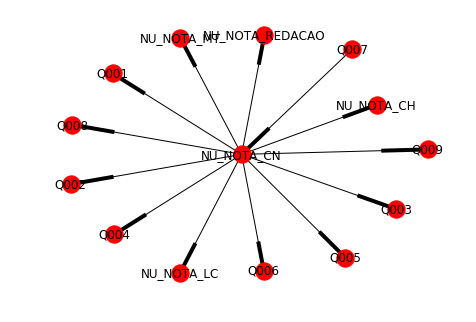

In [81]:
nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
plt.show();

### Estudo de variáveis (sample_size reduzido)

5 variáveis - 3s

14 variáveos - 4 minutos

16 variáveis - 7 minutos

18 variáveis - 11 minutos

20 variáveis - 17 minutos

24 variáveis - 30 minutos

In [7]:
pandas_sample = pandas_df.sample(frac=0.1,random_state=17)

In [8]:
est = HillClimbSearch(pandas_sample[grades+['Q00{}'.format(i) for i in range(1,10)]],
                      scoring_method=BicScore(pandas_sample[grades+['Q00{}'.format(i) for i in range(1,10)]]))

In [9]:
%%time
best_model = est.estimate()

CPU times: user 4min 33s, sys: 218 ms, total: 4min 33s
Wall time: 4min 33s


In [10]:
len(sorted(best_model.nodes()))

14

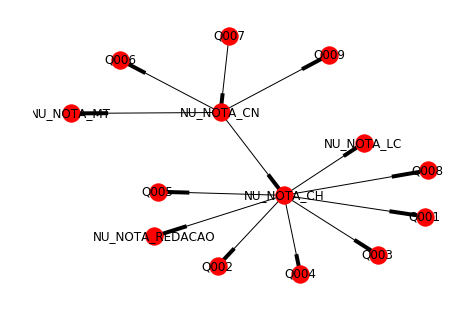

In [11]:
nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
plt.show();

# Increasing the Number of Variables

Reducing Sample Size
Vou considerar apenas a nota de matemática como variável resposta. Como quero avaliar a relação de todas as perguntas do questionário em relação às notas e dado o aumento em relação à complexidade, parece a melhor coisa a se fazer.

In [53]:
columns = ['NU_NOTA_MT']+['Q00{}'.format(i) for i in range(1,10)]+['Q0{}'.format(i) for i in range(10,28)]

In [55]:
est = HillClimbSearch(pandas_sample[columns],
                      scoring_method=BicScore(pandas_sample[columns]))

In [26]:
%%time
best_model = est.estimate()

CPU times: user 33min 44s, sys: 1.05 s, total: 33min 45s
Wall time: 33min 45s


In [28]:
len(sorted(best_model.nodes()))

24

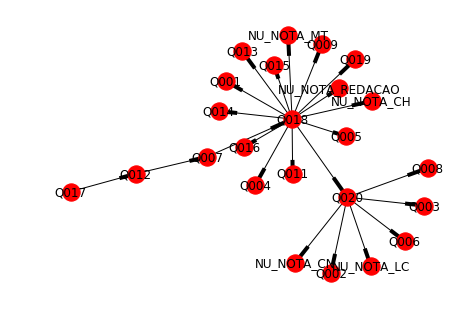

In [29]:
nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
plt.show();

# Parameter Learning

Using Bayesian Estimator

In [30]:
for cpd in best_model.get_cpds():
    print(cpd)

In [34]:
est = BayesianEstimator(best_model, pandas_sample[grades\
                                    +['Q00{}'.format(i) for i in range(1,10)]\
                                    +['Q0{}'.format(i) for i in range(11,21)]])

In [38]:
%%time
print(est.estimate_cpd('NU_NOTA_MT', prior_type='BDeu', equivalent_sample_size=10))

╒════════════════════════╤═════════╤═════════╕
│ Q018                   │ Q018(A) │ Q018(B) │
├────────────────────────┼─────────┼─────────┤
│ NU_NOTA_MT(alta)       │ 0.25    │ 0.25    │
├────────────────────────┼─────────┼─────────┤
│ NU_NOTA_MT(baixa)      │ 0.25    │ 0.25    │
├────────────────────────┼─────────┼─────────┤
│ NU_NOTA_MT(media)      │ 0.25    │ 0.25    │
├────────────────────────┼─────────┼─────────┤
│ NU_NOTA_MT(muito alta) │ 0.25    │ 0.25    │
╘════════════════════════╧═════════╧═════════╛
CPU times: user 74.6 ms, sys: 2 ms, total: 76.6 ms
Wall time: 74.7 ms


In [41]:
%%time
best_model.fit(pandas_sample, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=1000)

CPU times: user 7.09 s, sys: 155 ms, total: 7.25 s
Wall time: 7.24 s


In [42]:
for cpd in best_model.get_cpds():
    print(cpd)

╒═══════════════════╤════════════════════╤════════════════════╕
│ Q020              │ Q020(A)            │ Q020(B)            │
├───────────────────┼────────────────────┼────────────────────┤
│ NU_NOTA_CN(alta)  │ 0.3333333333333333 │ 0.3333333333333333 │
├───────────────────┼────────────────────┼────────────────────┤
│ NU_NOTA_CN(baixa) │ 0.3333333333333333 │ 0.3333333333333333 │
├───────────────────┼────────────────────┼────────────────────┤
│ NU_NOTA_CN(media) │ 0.3333333333333333 │ 0.3333333333333333 │
╘═══════════════════╧════════════════════╧════════════════════╛
╒═══════════════════╤════════════════════╤════════════════════╕
│ Q018              │ Q018(A)            │ Q018(B)            │
├───────────────────┼────────────────────┼────────────────────┤
│ NU_NOTA_CH(alta)  │ 0.3333333333333333 │ 0.3333333333333333 │
├───────────────────┼────────────────────┼────────────────────┤
│ NU_NOTA_CH(baixa) │ 0.3333333333333333 │ 0.3333333333333333 │
├───────────────────┼───────────────────

# Inference

## Cenário 1

- Pais pós graduados
- Salário em torno de 10 mil reais
- Com TV por Assinatura
- Dois computador
- Com acesso a internet

In [ ]:
# Doing exact inference using Variable Elimination
from pgmpy.inference import VariableElimination
enem_infer = VariableElimination(best_model)

# Computing the probability of bronc given smoke.
q = enem_infer.query(variables=['NU_NOTA_MT'], evidence={'Q001': 'G','Q002':'G','Q006':'N','Q:021':'A','Q024':'C','Q025':'B'})
print(q['NU_NOTA_MT'])

## Cenário 2

- Pais nunca estudaram
- Salário em torno de 2500 reais
- Sem TV por Assinatura
- Sem computador
- Sem acesso a internet

In [ ]:
q = enem_infer.query(variables=['NU_NOTA_MT'], evidence={'Q001': 'A','Q002':'A','Q006':'F','Q:021':'B','Q024':'A','Q025':'A'})
print(q['NU_NOTA_MT'])

## Cenário 3

- Sem inernet em casa

In [ ]:
q = enem_infer.query(variables=['NU_NOTA_MT'], evidence={'Q025':'B'})
print(q['NU_NOTA_MT'])

## Cenário 4

- Com inernet em casa

In [ ]:
q = enem_infer.query(variables=['NU_NOTA_MT'], evidence={'Q025':'A'})
print(q['NU_NOTA_MT'])

## Cenário 5

- Parte em escola pública, parte em particular, com Bolsa

In [ ]:
# Computing the probability of bronc given smoke.
q = enem_infer.query(variables=['NU_NOTA_MT'], evidence={'Q027':'C'})
print(q['NU_NOTA_MT'])

## Cenário 6

- Somente escola Privada

In [ ]:
# Computing the probability of bronc given smoke.
q = enem_infer.query(variables=['NU_NOTA_MT'], evidence={'Q027':'D'})
print(q['NU_NOTA_MT'])

## Cenário 7

- Somente escola Pública

In [ ]:
# Computing the probability of bronc given smoke.
q = enem_infer.query(variables=['NU_NOTA_MT'], evidence={'Q027':'A'})
print(q['NU_NOTA_MT'])